In [1]:
import sys
sys.path.insert(1, '../..')

import torch
import torch.nn as nn
import random
import pandas as pd
import numpy as np
import time

from library.evaluation import ConfusionMatrix

random.seed(33)

unique_name = "DistilBERT_Finetuned"

In [2]:
vectors = np.loadtxt("../../data/processed/vectors/Phemernr2_DistilBERT_base_finetuned_vectors.txt", delimiter=",")
first = vectors[0]
vectors.shape

(6425, 768)

In [3]:
data = pd.read_csv("../../data/processed/phemernr2_dataset_with_tvt.csv", lineterminator="\n")
data.head()

,tweet_id,tweet_text,label,label2,topic,tvt,cv_fold,tt,tvt2
0,552833795142209536,The East London Mosque would like to offer its...,non-rumours,non-rumours,charliehebdo-all-rnr-threads,test,2,test,testting
1,580318210609696769,BREAKING - A Germanwings Airbus A320 plane rep...,rumours,true,germanwings-crash-all-rnr-threads,training,3,training,training
2,552798891994009601,Reports that two of the dead in the #CharlieHe...,rumours,true,charliehebdo-all-rnr-threads,test,2,test,validation
3,576790814942236672,After #Putin disappeared Russian TV no longer ...,non-rumours,non-rumours,putinmissing-all-rnr-threads,test,2,test,training
4,499678822598340608,Saw #Ferguson for myself. #justiceformichaelbr...,non-rumours,non-rumours,ferguson-all-rnr-threads,training,3,training,training


In [4]:
labels_str = data['label2'].unique().tolist()
labels_str

['non-rumours', 'true', 'unverified', 'false']

In [5]:
labels = []
for i, d in data.iterrows():
    lab = labels_str.index(d['label2'])
    labels.append(lab)
labels[:10]

[0, 1, 1, 0, 0, 0, 0, 2, 0, 0]

In [6]:
train_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

train_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

In [7]:
print(train_vectors.shape)
print(val_vectors.shape)
print(test_vectors.shape)

print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(4323, 768)
(1418, 768)
(684, 768)
(4323,)
(1418,)
(684,)


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes):
        super(BasicBlock, self).__init__()
        self.lin1 = nn.Linear(in_planes, planes)
        self.bn1 = nn.BatchNorm1d(planes)
        self.lin2 = nn.Linear(planes, planes)
        self.bn2 = nn.BatchNorm1d(planes)

        self.shortcut = nn.Sequential()
        if in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Linear(in_planes, planes),
                nn.BatchNorm1d(planes)
            )

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.lin1(x)), 0.1)
        out = self.bn2(self.lin2(out))
        out += self.shortcut(x)
        out = F.leaky_relu(out, 0.1)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes):
        super(Bottleneck, self).__init__()
        self.lin1 = nn.Linear(in_planes, planes)
        self.bn1 = nn.BatchNorm1d(planes)
        self.lin2 = nn.Linear(planes, planes)
        self.bn2 = nn.BatchNorm1d(planes)
        self.lin3 = nn.Linear(planes, planes)
        self.bn3 = nn.BatchNorm1d(planes)

        self.shortcut = nn.Sequential()
        if in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Linear(in_planes, planes),
                nn.BatchNorm1d(planes)
            )

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.lin1(x)), 0.1)
        out = F.leaky_relu(self.bn2(self.lin2(out)), 0.1)
        out = self.bn3(self.lin3(out))
        out += self.shortcut(x)
        out = F.leaky_relu(out, 0.1)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, n_input=768, num_classes=1):
        super(ResNet, self).__init__()
        self.in_planes = 512

        self.lin1 = nn.Linear(n_input, self.in_planes)
        self.bn1 = nn.BatchNorm1d(self.in_planes)
        self.layer1 = self._make_layer(block, 512, num_blocks[0])
        self.layer2 = self._make_layer(block, 256, num_blocks[1])
        self.layer3 = self._make_layer(block, 128, num_blocks[2])
        self.layer4 = self._make_layer(block, 64, num_blocks[3])
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_blocks):
        strides = [1] * num_blocks
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.lin1(x)), 0.1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet10(n_input=768, n_output=1, block=BasicBlock):
    return ResNet(block, [1, 1, 1, 1], n_input, n_output)

    
def ResNet18(n_input=768, n_output=1, block=BasicBlock):
    return ResNet(block, [2, 2, 2, 2], n_input, n_output)


def ResNet34(n_input=768, n_output=1, block=BasicBlock):
    return ResNet(block, [3, 4, 6, 3], n_input, n_output)


def ResNet50(n_input=768, n_output=1, block=Bottleneck):
    return ResNet(block, [3, 4, 6, 3], n_input, n_output)


def ResNet101(n_input=768, n_output=1, block=Bottleneck):
    return ResNet(block, [3, 4, 23, 3], n_input, n_output)


def ResNet152(n_input=768, n_output=1, block=Bottleneck):
    return ResNet(block, [3, 8, 36, 3], n_input, n_output)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CNNBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(CNNBasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.conv1(x)), 0.1)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.leaky_relu(out, 0.1)
        return out


class CNNBottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes):
        super(CNNBottleneck, self).__init__()
        self.lin1 = nn.Linear(in_planes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.lin2 = nn.Linear(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.lin3 = nn.Linear(planes, planes)
        self.bn3 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Linear(in_planes, planes),
                nn.BatchNorm1d(planes)
            )

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.lin1(x)), 0.1)
        out = F.leaky_relu(self.bn2(self.lin2(out)), 0.1)
        out = self.bn3(self.lin3(out))
        out += self.shortcut(x)
        out = F.leaky_relu(out, 0.1)
        return out


class CNNResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1):
        super(CNNResNet, self).__init__()
        self.in_planes = 24

        self.conv1 = nn.Conv2d(1, 24, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(24)
        self.layer1 = self._make_layer(block, 24, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 48, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 64, num_blocks[3], stride=2)
        self.linear = nn.Linear(64 * 24 * 32, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.conv1(x)), 0.1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def CNNResNet10(n_output: int):
    return CNNResNet(CNNBasicBlock, [1, 1, 1, 1], n_output)

    
def CNNResNet18(n_output: int):
    return CNNResNet(CNNBasicBlock, [2, 2, 2, 2], n_output)


def CNNResNet34(n_output: int):
    return CNNResNet(CNNBasicBlock, [3, 4, 6, 3], n_output)


def CNNResNet50(n_output: int):
    return CNNResNet(CNNBottleneck, [3, 4, 6, 3], n_output)


def CNNResNet101(n_output: int):
    return CNNResNet(CNNBottleneck, [3, 4, 23, 3], n_output)


def CNNResNet152(n_output: int):
    return CNNResNet(CNNBottleneck, [3, 8, 36, 3], n_output)

In [10]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
from typing import Callable


class ResNetClassifier(nn.Module):
    def __init__(self,
        model,
        n_input: int,
        n_output: int = 1,
        criterion: Callable = nn.BCELoss,
        n_features: int = 4,
        lr: float = 0.0002,
        beta1: float = 0.5,
        device: str = None,
        model_type: str = "mlp"
    ):
        super(ResNetClassifier, self).__init__()
        self.model = model
        self.model_type = model_type
        self.criterion = criterion()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=(beta1, 0.999))
        
        if not device or device not in ['cpu', 'cuda']:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device

        self.model = self.model.to(self.device)
        if self.device == 'cuda':
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True

    def forward(self, input):
        x = self.model(input)
        return x
    
    def load_pretrained(self, filepath: str, key: str = "net", is_parallel: bool = False):
        checkpoint = torch.load(filepath)
        if is_parallel:
            self.model = torch.nn.DataParallel(self.model)
        self.model.load_state_dict(checkpoint[key], strict=False)
    
    def save_model(self, saves: str):
        print(f"Saving model...")
        state = {
            'net': self.model.state_dict()
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f"../../data/models/{saves}.pth")
    
    def train_eval(self,
        train_x, train_y,
        test_x, test_y,
        n_iter: int = 100,
        batch_size: int = 128,
        saves: str = None
    ):
        trainset = torch.utils.data.TensorDataset(train_x, train_y) # create your datset
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size) # create your dataloader

        testset = torch.utils.data.TensorDataset(test_x, test_y) # create your datset
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size) # create your dataloader

        train_accs = []
        train_losses = []
        test_accs = []
        test_losses = []

        print(f"Using {self.device}")
        best_acc = 0
        current_loss = 1000
        best_test_acc = 0
        epoch = 0
        start_time = time.time()
        results = {}
        while True:
            epoch += 1
            self.model.train()
            train_loss = 0
            correct = 0
            total = 0
            for batch_idx, (inputs, targets) in enumerate(trainloader):
                self.model.zero_grad()
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                if self.model_type == "cnn":
                    outputs = self.model(inputs.unsqueeze(1))
                elif self.model_type == "mlp":
                    outputs = self.model(inputs)

                loss = self.criterion(outputs, targets.long())
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                total += targets.size(0)
#                 for i, output in enumerate(outputs.tolist()):
#                     if targets[i,0].tolist() == round(output[0]):
#                         correct += 1

#             train_acc = round(100*correct/total, 4)
#             train_accs.append(train_acc)
            train_losses.append(train_loss)

            self.model.eval()
            test_loss = 0
            test_acc = 0
            with torch.no_grad():
                inputs, targets = test_x.to(self.device), test_y.to(self.device)
                
                if self.model_type == 'mlp':
                    outputs = self.model(inputs)
                else:
#                     outputs = self.model(inputs.reshape(inputs.shape[0], 1, 24, 32))
                    outputs = self.model(inputs.unsqueeze(1))

                loss = self.criterion(outputs, targets.long())
                test_loss += loss.item()
                
                if self.model_type == 'mlp':
                    preds = self.predict(test_x)
                else:
                    preds = self.predict(test_x.reshape(test_x.shape[0], 1, 24, 32))
                conf_mat = ConfusionMatrix(
                    labels=np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in test_y]),
                    predictions=np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds.cpu().numpy()]),
                    binary=False
                )
                conf_mat.evaluate(logs=False)
                test_acc = conf_mat.accuracy

            test_losses.append(test_loss)
            
            if (epoch) % round(n_iter/20) == 0:
                print(f"-- Epoch {epoch}, Train Loss : {train_loss}, Test Loss : {test_loss}")

            # Save checkpoint.
#             if saves and test_loss < best_loss:
#                 print(f"Saving after new best loss : {test_loss}")
#                 best_loss = test_loss
            if saves and test_acc > best_test_acc:
                print(f"Saving after new best accuracy : {test_acc}")
                best_test_acc = test_acc

                state = {
                    'net': self.model.state_dict(),
                }
                if not os.path.isdir('models'):
                    os.mkdir('models')
                torch.save(state, f"../../data/models/{saves}.pth")
            
            if epoch >= n_iter:
                break

        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)

        ax2.plot([i for i in range(len(train_losses))], train_losses, c='b', marker="o", label='Train Loss')
        ax2.plot([i for i in range(len(test_losses))], test_losses, c='r', marker="o", label='Test Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_xlim(0, len(train_losses))
        ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Loss over time (epoch)")
        ax2.legend(loc='lower right')

        plt.show()
    
    def predict(self, input_x):
        self.model.eval()
        with torch.no_grad():
            preds = self.model(torch.Tensor(input_x))
            preds = torch.log_softmax(preds, dim = 1)
            _, preds = torch.max(preds, dim = 1)
            return preds

Multiclass Classification Phemernr2_multiclass_ResNet10_CNN_DistilBERT_Finetuned
Using cuda
Saving after new best accuracy : 60.86
Saving after new best accuracy : 76.446
Saving after new best accuracy : 83.286
Saving after new best accuracy : 83.427
Saving after new best accuracy : 83.992
Saving after new best accuracy : 84.133
Saving after new best accuracy : 84.274
-- Epoch 50, Train Loss : 0.0039622497133677825, Test Loss : 1.5175092220306396
-- Epoch 100, Train Loss : 0.0032384324513259344, Test Loss : 1.6003884077072144
-- Epoch 150, Train Loss : 0.0032155338376469444, Test Loss : 1.6496342420578003
-- Epoch 200, Train Loss : 0.00321209083267604, Test Loss : 1.6830613613128662
-- Epoch 250, Train Loss : 0.0031469654950342374, Test Loss : 1.707400918006897
-- Epoch 300, Train Loss : 0.0030348721284099156, Test Loss : 1.7264175415039062
-- Epoch 350, Train Loss : 0.00288414784881752, Test Loss : 1.7440568208694458
-- Epoch 400, Train Loss : 0.0027110543232993223, Test Loss : 1.7570

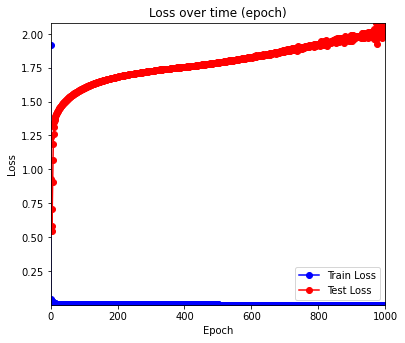

Exec Time : 666.69 seconds

---- Validation Set ----
Predictions : torch.Size([1418])
1418 vs 1418
Multi Class Evaluation

Class non-rumours Evaluation
- Precision : 88.669 %
- Recall : 91.28 %
- F1 : 0.89955

Class true Evaluation
- Precision : 76.446 %
- Recall : 76.763 %
- F1 : 0.76605

Class unverified Evaluation
- Precision : 63.946 %
- Recall : 62.252 %
- F1 : 0.63087

Class false Evaluation
- Precision : 91.667 %
- Recall : 76.923 %
- F1 : 0.8365

Combined Evaluation
- Accuracy : 84.274 %
- Precision : 80.182 %
- Recall : 76.804 %
- F1 : 0.78457

- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,true,,,unverified,,,false,,,
Phemernr2_multiclass_ResNet10_CNN_DistilBERT_Finetuned Validation, 84.274, 80.182, 76.804, 0.78457, 88.669, 91.28, 0.89955, 76.446, 76.763, 0.76605, 63.946, 62.252, 0.63087, 91.667, 76.923, 0.8365, 

---- Test Set ----
Predictions : torch.Size([684])
684 vs 684
Multi Class Evaluation

Class non-rumours Evaluation
- Precision : 86.534 %
- Recall 

In [11]:
model_name = f"Phemernr2_multiclass_ResNet10_CNN_{unique_name}"
start = time.time()
print(f"Multiclass Classification {model_name}")
model = ResNetClassifier(CNNResNet10(n_output=4), train_vectors.shape[1], n_output=4, criterion=nn.CrossEntropyLoss, n_features=16, model_type="cnn") #, device="cpu")
model.train_eval(torch.Tensor(train_vectors.reshape(train_vectors.shape[0], 24, 32)),
                torch.Tensor(train_labels),
                torch.Tensor(val_vectors.reshape(val_vectors.shape[0], 24, 32)),
                torch.Tensor(val_labels),
                saves=model_name,
                n_iter=1000,
                batch_size=1024)
print(f"Exec Time : {round(time.time() - start, 2)} seconds")

model.load_pretrained(f"../../data/models/{model_name}.pth")

print("\n---- Validation Set ----")
preds = model.predict(val_vectors.reshape(val_vectors.shape[0], 1, 24, 32))
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()

conf_mat = ConfusionMatrix(
    labels=np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in val_labels]),
    predictions=np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds]),
    binary=False,
    model_name=f"{model_name} Validation"
)
conf_mat.evaluate(classes=labels_str)

print("\n---- Test Set ----")
preds = model.predict(test_vectors.reshape(test_vectors.shape[0], 1, 24, 32))
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()

conf_mat = ConfusionMatrix(
    labels=np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in test_labels]),
    predictions=np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds]),
    binary=False,
    model_name=f"{model_name} Validation"
)
conf_mat.evaluate(classes=labels_str)

Multiclass Classification Phemernr2_multiclass_ResNet18_CNN_DistilBERT_Finetuned
Using cuda
Saving after new best accuracy : 13.611
Saving after new best accuracy : 28.984
Saving after new best accuracy : 29.69
Saving after new best accuracy : 69.676
Saving after new best accuracy : 82.37
Saving after new best accuracy : 83.145
Saving after new best accuracy : 83.498
Saving after new best accuracy : 83.568
Saving after new best accuracy : 83.709
-- Epoch 50, Train Loss : 0.0029376106103882194, Test Loss : 1.5774580240249634
-- Epoch 100, Train Loss : 0.002994081314682262, Test Loss : 1.6371395587921143
Saving after new best accuracy : 83.78
-- Epoch 150, Train Loss : 0.0032887810593820177, Test Loss : 1.6693867444992065
Saving after new best accuracy : 83.85
Saving after new best accuracy : 83.921
-- Epoch 200, Train Loss : 0.0032508784825040493, Test Loss : 1.694127082824707
-- Epoch 250, Train Loss : 0.0029407296260615112, Test Loss : 1.708806037902832
-- Epoch 300, Train Loss : 0.00

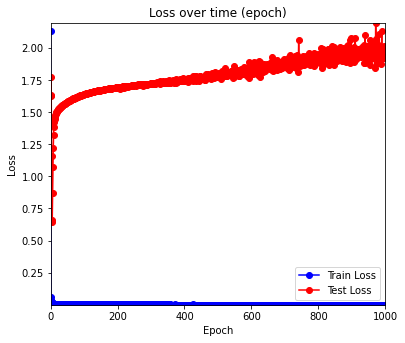

Exec Time : 1189.57 seconds

---- Validation Set ----
Predictions : torch.Size([1418])
1418 vs 1418
Multi Class Evaluation

Class non-rumours Evaluation
- Precision : 89.298 %
- Recall : 90.713 %
- F1 : 0.9

Class true Evaluation
- Precision : 76.518 %
- Recall : 78.423 %
- F1 : 0.77459

Class unverified Evaluation
- Precision : 64.189 %
- Recall : 62.914 %
- F1 : 0.63545

Class false Evaluation
- Precision : 88.889 %
- Recall : 78.322 %
- F1 : 0.83271

Combined Evaluation
- Accuracy : 84.415 %
- Precision : 79.723 %
- Recall : 77.593 %
- F1 : 0.78644

- Average Confidence : 100.0 %
Model, Combined,,,,non-rumours,,,true,,,unverified,,,false,,,
Phemernr2_multiclass_ResNet18_CNN_DistilBERT_Finetuned Validation, 84.415, 79.723, 77.593, 0.78644, 89.298, 90.713, 0.9, 76.518, 78.423, 0.77459, 64.189, 62.914, 0.63545, 88.889, 78.322, 0.83271, 

---- Test Set ----
Predictions : torch.Size([684])
684 vs 684
Multi Class Evaluation

Class non-rumours Evaluation
- Precision : 86.696 %
- Recall : 9

In [12]:
model_name = f"Phemernr2_multiclass_ResNet18_CNN_{unique_name}"
start = time.time()
print(f"Multiclass Classification {model_name}")
model = ResNetClassifier(CNNResNet18(n_output=4), train_vectors.shape[1], n_output=4, criterion=nn.CrossEntropyLoss, n_features=16, model_type="cnn") #, device="cpu")
model.train_eval(torch.Tensor(train_vectors.reshape(train_vectors.shape[0], 24, 32)),
                torch.Tensor(train_labels),
                torch.Tensor(val_vectors.reshape(val_vectors.shape[0], 24, 32)),
                torch.Tensor(val_labels),
                saves=model_name,
                n_iter=1000,
                batch_size=1024)
print(f"Exec Time : {round(time.time() - start, 2)} seconds")

model.load_pretrained(f"../../data/models/{model_name}.pth")

print("\n---- Validation Set ----")
preds = model.predict(val_vectors.reshape(val_vectors.shape[0], 1, 24, 32))
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()

conf_mat = ConfusionMatrix(
    labels=np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in val_labels]),
    predictions=np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds]),
    binary=False,
    model_name=f"{model_name} Validation"
)
conf_mat.evaluate(classes=labels_str)

print("\n---- Test Set ----")
preds = model.predict(test_vectors.reshape(test_vectors.shape[0], 1, 24, 32))
print(f"Predictions : {preds.shape}")

preds = preds.cpu().numpy()

conf_mat = ConfusionMatrix(
    labels=np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in test_labels]),
    predictions=np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds]),
    binary=False,
    model_name=f"{model_name} Validation"
)
conf_mat.evaluate(classes=labels_str)